# Exploring Data from multiple sources

In [1]:
pip install rasterio numpy matplotlib geopandas shapely xarray pyproj

Note: you may need to restart the kernel to use updated packages.


In [119]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 11.2 MB/s eta 0:00:00


In [2]:
import csv
import pandas as pd
import os
import xarray as xr
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
import rasterio
from datetime import datetime

### San Bernardino County, CA data points on drought
combined two datasets --> one with observed, monitored drought data and one with replicated, "predicted" drought data. Because the monitored drought data only starts from 2000, we decided to take the "historical" drought data from 1950 to 1999 and concatenate it with the observed dataset.

In [ ]:
path = os.getcwd()

new_drought_df = pd.read_csv(path + '/data/SB_DroughtConditions.csv')
# print(new_drought_df.head())

# subset data so that it only includes dates from 2000 - 2024
# print(new_drought_df.dtypes)
new_drought_df = new_drought_df[new_drought_df['MapDate'] >= 20000101]
new_drought_df = new_drought_df[new_drought_df['MapDate'] <= 20241231]
# print(new_drought_df.head())

historical_drought_df = pd.read_csv(path + '/data/SB_historical_drought.csv')
# print(historical_drought_df.head())

# extract needed columns about drought
historical_drought_df = historical_drought_df[['DATE', 'D0', 'D1', 'D2', 'D3', 'D4']]
# print(historical_drought_df.dtypes)
# splice date string to only include yyyymmdd
historical_drought_df['DATE'] = historical_drought_df['DATE'].str[2:]
# subset data so that it only includes dates from 1950 - 1999
historical_drought_df = historical_drought_df[historical_drought_df['DATE'] >= "19500101"]
historical_drought_df = historical_drought_df[historical_drought_df['DATE'] <= "19991231"]

historical_drought_df.rename(columns={'DATE': 'date'}, inplace=True)
# # convert date column to datetime format
# historical_drought_df['date'] = pd.to_datetime(historical_drought_df['date'])
# # format the datetime objects to 'yyyy-mm'
# historical_drought_df['date'] = historical_drought_df['date'].dt.strftime('%Y-%m')
historical_drought_df.reset_index(drop=True, inplace=True)
# print(historical_drought_df.head())

# combine datasets
new_drought_df.rename(columns={'MapDate': 'date'}, inplace=True)
new_drought_df = new_drought_df[['date', 'D0', 'D1', 'D2', 'D3', 'D4']]
# print(new_drought_df.head())

# rename column DATE of historical_drought_df
historical_drought_df.rename(columns={'DATE': 'date'}, inplace=True)

# merge datasets
drought_df = pd.concat([historical_drought_df, new_drought_df], axis=0)
print(drought_df.head())

       date    D0    D1    D2    D3    D4
0  19500101  90.1  83.9  57.9  40.8  16.1
1  19500201  92.7  89.4  72.4  50.8  13.1
2  19500301  95.8  90.4  68.8  48.5   8.3
3  19500401  96.1  90.9  70.6  43.6   0.2
4  19500501  97.5  90.8  76.8  29.2   0.1


In [108]:
drought_df.to_csv("SB_drought_labels.csv", index=False)

#### take drought_df with all drought labels and group by month

In [110]:
# convert date column to datetime format
drought_df['date'] = pd.to_datetime(drought_df['date'])

drought_df = drought_df.groupby(drought_df['date'].dt.to_period('M'))[['D0', 'D1', 'D2', 'D3', 'D4']].mean().reset_index()
print(drought_df.head())

# format the datetime objects to 'yyyy-mm'
drought_df['date'] = drought_df['date'].dt.strftime('%Y-%m')

# make into csv and store in historical_all
new_dir = path + '/data/historical_all'
os.makedirs(new_dir, exist_ok=True)

# make all df into csv files in new directory
new_filepath = os.path.join(new_dir, "SB_historical_drought_labels.csv")
with open(new_filepath, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(drought_df)

      date    D0    D1    D2    D3    D4
0  1950-01  90.1  83.9  57.9  40.8  16.1
1  1950-02  92.7  89.4  72.4  50.8  13.1
2  1950-03  95.8  90.4  68.8  48.5   8.3
3  1950-04  96.1  90.9  70.6  43.6   0.2
4  1950-05  97.5  90.8  76.8  29.2   0.1


### PRISM data preprocessing

In [ ]:
from rasterio.windows import Window

def load_prism_data(base_path):
    """Load PRISM data with robust error handling"""
    data = []
    dates = []
    
    for root, dirs, files in os.walk(base_path):
        for dir_name in dirs:
            try:
                # Skip non-date folders
                date = datetime.strptime(dir_name, '%Y%m%d')
                dir_path = os.path.join(root, dir_name)
                
                # Look for .bil files (common PRISM format)
                for file in os.listdir(dir_path):
                    if file.endswith(".bil"):
                        file_path = os.path.join(dir_path, file)
                        try:
                            with rasterio.open(file_path) as src:
                                # Read first 1000x1000 pixels to verify data
                                array = src.read(1, window=Window(0, 0, 1000, 1000))
                                if np.all(array == src.nodata):
                                    print(f"No valid data in {file}")
                                    continue
                                data.append(np.nanmean(array))
                                dates.append(date.strftime('%Y-%m-%d'))
                        except rasterio.errors.RasterioIOError as e:
                            print(f"Error reading {file}: {str(e)}")
                            
            except ValueError:
                continue
                
    return pd.DataFrame({'Date': dates, 'PRISM_Value': data})

In [ ]:
# Main execution
prism_folder = path + "/data/prism_unzipped"
water_drought_path = path + "/data/water_drought.csv"

print(water_drought_path)
water_drought = pd.read_csv(water_drought_path)

# Load and merge data
prism_df = load_prism_data(prism_folder)
print(prism_df)

# Convert 'Date' in water_drought to datetime
water_drought['Date'] = pd.to_datetime(water_drought['Date'], errors='coerce')

# Convert 'Date' in prism_df to datetime (if not already done)
prism_df['Date'] = pd.to_datetime(prism_df['Date'], errors='coerce')

print("Water Drought Date dtype:", water_drought['Date'].dtype)
print("PRISM Date dtype:", prism_df['Date'].dtype)

final_df = pd.merge(
    water_drought.dropna(subset=['Date']),  # Remove invalid dates
    prism_df.dropna(subset=['Date']), 
    on='Date', 
    how='inner'  # Use 'inner' to ensure overlapping dates
)

print("Merged Data Sample:\n", final_df.head())

/Users/aimeeoh/Desktop/Documents/ColumbiaMS/MLC/ML-Climate/water_drought.csv
            Date  PRISM_Value
0     2019-07-09 -3388.621094
1     2023-06-18 -3389.373047
2     2021-08-11 -3390.122070
3     2022-02-28 -3390.125000
4     2022-08-26 -3389.744141
...          ...          ...
1821  2023-08-09 -3389.605469
1822  2019-03-16 -3390.907471
1823  2019-09-18 -3389.377441
1824  2019-01-24 -3388.126709
1825  2020-11-24 -3390.504150

[1826 rows x 2 columns]
Water Drought Date dtype: datetime64[ns]
PRISM Date dtype: datetime64[ns]
Merged Data Sample:
         Date      D0     D1     D2   D3   D4  Drought_Index  \
0 2019-01-01  100.00  99.84  10.88  0.0  0.0         45.392   
1 2019-01-08  100.00  99.84  10.88  0.0  0.0         45.392   
2 2019-01-15  100.00  99.84   9.97  0.0  0.0         44.937   
3 2019-01-22  100.00  82.69   0.00  0.0  0.0         34.807   
4 2019-01-29   99.85   8.20   0.00  0.0  0.0         12.445   

   RC1a_Temperature_Change  RC1c_Wildfire_Projections  RC2b_Wild

Accuracy is variable. Goes form 0.74 to 0.9. Should do multiple runs of model? And should make model more robust. Maybe more data.

this is more classification --> change to prediction. Given this time period, predict the next week?

take weather, precipitation, and  --> datasets that give data on future date's climate

Do this after getting data --> causality with DoWhy --> codes up DAG

find the years that may have bad droughts/worst drought conditions

dew point (single value) if we're measuring one day (random day i.e. Jan 1st, 2066)
dew point if we have the previous week --> predict the next week (base off of trend/variability of temp, precip, dew point, humidity)

groundwater data for san bernardino

extract ppt, dp, etc. from tif file (maybe didn't do in the first run? -- find out)

Groundwater data -- combine dates from different well sites to get aggregate groundwater data per unique day.

In [5]:
# Load CSV data
df = pd.read_csv("SB_groundwater.csv", parse_dates=['datetime'])

# 1. Clean data: Ensure numeric values and filter provisional data (optional)
df['parameter_value'] = pd.to_numeric(df['parameter_value'], errors='coerce')
# df = df[df['qualification_cd'] == 'A']  # Uncomment to use only approved data

# 2. Group by date and sum parameter values
daily_totals = df.groupby('datetime', as_index=False).agg({
    'parameter_value': 'sum',
    'agency_cd': 'first'  # Assumes all rows are USGS
})

# 3. Rename columns and handle missing data
daily_totals = daily_totals.rename(columns={
    'parameter_value': 'total_parameter_value'
}).fillna(0)

# 4. Save consolidated data
daily_totals.to_csv("daily_groundwater_totals.csv", index=False)

print(daily_totals.head())

/var/folders/h6/vygxj7rj5tq9z54ggx6zd6080000gn/T/ipykernel_57915/1205911318.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("SB_groundwater.csv", parse_dates=['datetime'])


    datetime  total_parameter_value agency_cd
0 2000-01-01              638157.71      USGS
1 2000-01-02              637681.42      USGS
2 2000-01-03              634953.66      USGS
3 2000-01-04              634403.38      USGS
4 2000-01-05              637111.66      USGS


label droughts by type (flash drought for times when we go from D0 to Dk in a short period of time)

prism data format explanation: https://prism.oregonstate.edu/formats/

### Drought data labels by month

In [ ]:
# convert drought_df['DATE'] row to datetime format
drought_df['date'] = pd.to_datetime(drought_df['date'])
print(drought_df.head())

# group data by month and get most frequent value per month
drought_monthlydf = drought_df.groupby(drought_df['date'].dt.to_period('M'))[['D0', 'D1', 'D2', 'D3', 'D4']].mean().reset_index()

# drought_monthlydf.columns = ['date', 'D0', 'D1', 'D2', 'D3', 'D4']
print(drought_monthlydf.head())


          date    D0    D1    D2    D3    D4
660 1950-01-01  90.1  83.9  57.9  40.8  16.1
661 1950-02-01  92.7  89.4  72.4  50.8  13.1
662 1950-03-01  95.8  90.4  68.8  48.5   8.3
663 1950-04-01  96.1  90.9  70.6  43.6   0.2
664 1950-05-01  97.5  90.8  76.8  29.2   0.1
      date    D0    D1    D2    D3    D4
0  1950-01  90.1  83.9  57.9  40.8  16.1
1  1950-02  92.7  89.4  72.4  50.8  13.1
2  1950-03  95.8  90.4  68.8  48.5   8.3
3  1950-04  96.1  90.9  70.6  43.6   0.2
4  1950-05  97.5  90.8  76.8  29.2   0.1


In [15]:
# convert to csv file
drought_monthlydf.to_csv("SB_monthly_drought_labels.csv", index=False)

### Get 1950-2013 observed historical data from livneh_vic and combine with predicted values from loca_vic HadGEM2-ES with rcp 8.5 to assume worst case baseline for carbon emissions for 2014-2024
different model information: 
1. HadGEM2-ES (warm/dry)
2. CanESM2 (average)
3. CNRM-CM5 (cooler/wetter)
4. MIROC5 the model least like the others to improve coverage of the range of outcomes

Change historical 1950-2013 data from daily to monthly to converge with loca-vic predictive data

In [67]:
# change daily to monthly
daily_airtemp2013 = pd.read_csv(path + '/data/livneh_vic/airtemp_daily.csv')
daily_baseflow2013 = pd.read_csv(path + '/data/livneh_vic/baseflow_daily.csv')
daily_ev2013 = pd.read_csv(path + '/data/livneh_vic/evapotranspiration_daily.csv')
daily_rainfall2013 = pd.read_csv(path + '/data/livneh_vic/rainfall_daily.csv')
daily_runoff2013 = pd.read_csv(path + '/data/livneh_vic/runoff_daily.csv')
daily_snowfall2013 = pd.read_csv(path + '/data/livneh_vic/snowfall_daily.csv')
daily_snowwater2013 = pd.read_csv(path + '/data/livneh_vic/snowwater_daily.csv')
daily_sm2013 = pd.read_csv(path + '/data/livneh_vic/soilmoisture_daily.csv')

dailydf = {"airtemp": daily_airtemp2013, 
           "baseflow": daily_baseflow2013, 
           "ev": daily_ev2013, 
           "rainfall": daily_rainfall2013, 
           "runoff": daily_runoff2013, 
           "snowfall": daily_snowfall2013, 
           "snowwater": daily_snowwater2013,
           "sm": daily_sm2013}

monthly2013_df = {}

for var, df in dailydf.items():
    df['date'] = pd.to_datetime(df['time'])
    column = df.columns[1]
    new_df = df.groupby(df['date'].dt.to_period('M'))[column].mean().reset_index()
    new_df.rename(columns={column: var}, inplace=True)
    # print(new_df.head())

    monthly2013_df[f"monthly_{var}2013"] = new_df

monthly_airtemp2013 = monthly2013_df['monthly_airtemp2013']
monthly_baseflow2013 = monthly2013_df['monthly_baseflow2013']
monthly_ev2013 = monthly2013_df['monthly_ev2013']
monthly_rainfall2013 = monthly2013_df['monthly_rainfall2013']
monthly_runoff2013 = monthly2013_df['monthly_runoff2013']
monthly_sm2013 = monthly2013_df['monthly_sm2013']
monthly_snowfall2013 = monthly2013_df['monthly_snowfall2013']
monthly_snowwater2013 = monthly2013_df['monthly_snowwater2013']

/var/folders/h6/vygxj7rj5tq9z54ggx6zd6080000gn/T/ipykernel_8990/1019791965.py:25: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  new_df = df.groupby(df['date'].dt.to_period('M'))[column].mean().reset_index()
/var/folders/h6/vygxj7rj5tq9z54ggx6zd6080000gn/T/ipykernel_8990/1019791965.py:25: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  new_df = df.groupby(df['date'].dt.to_period('M'))[column].mean().reset_index()
/var/folders/h6/vygxj7rj5tq9z54ggx6zd6080000gn/T/ipykernel_8990/1019791965.py:25: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  new_df = df.groupby(df['date'].dt.to_period('M'))[column].mean().reset_index()
/var/folders/h6/vygxj7rj5tq9z54ggx6zd6080000gn/T/ipykernel_8990/1019791965.py:25: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  new_df = df.groupby(df['date'].dt.to_period('M'))[column].m

load loca-vic data and merge with the 1950-2013 dataa

In [ ]:
# load loca-vic rcp 8.5 data for all variables
# sample folder name that has projected values: projected_baseflow_2006_2099_monthly
# sample file name: tair_month_HadGEM2-ES_rcp85.csv

model = "HadGEM2-ES"
emissions = "rcp85"
monthlydf_names = ["airtemp", "baseflow", "ev", "rainfall", "runoff", "snowfall", "snowwater", "sm"]

monthly2024_df = {}
for t in monthlydf_names:
    new_df = pd.read_csv(path + f'/data/projected_{t}_2006_2099_monthly/{t}_month_{model}_{emissions}.csv')
    column = new_df.columns[1]
    new_df.rename(columns={column: t}, inplace=True)

    new_df.rename(columns={'time': 'date'}, inplace=True)
    
    # convert date column to datetime format
    new_df['date'] = pd.to_datetime(new_df['date'])
    # format the datetime objects to 'yyyy-mm'
    new_df['date'] = new_df['date'].dt.strftime('%Y-%m')

    monthly2024_df[f"monthly_{t}2024"] = new_df

monthly_airtemp2024 = monthly2024_df['monthly_airtemp2024']
monthly_baseflow2024 = monthly2024_df['monthly_baseflow2024']
monthly_ev2024 = monthly2024_df['monthly_ev2024']
monthly_rainfall2024 = monthly2024_df['monthly_rainfall2024']
monthly_runoff2024 = monthly2024_df['monthly_runoff2024']
monthly_sm2024 = monthly2024_df['monthly_sm2024']
monthly_snowfall2024 = monthly2024_df['monthly_snowfall2024']
monthly_snowwater2024 = monthly2024_df['monthly_snowwater2024']

In [85]:
# merge with monthly_{var_type}2013

airtemp_df = pd.concat([monthly_airtemp2013, monthly_airtemp2024], axis=0)
baseflow_df = pd.concat([monthly_baseflow2013, monthly_baseflow2024], axis=0)
ev_df = pd.concat([monthly_ev2013, monthly_ev2024], axis=0)
rainfall_df = pd.concat([monthly_rainfall2013, monthly_rainfall2024], axis=0)
runoff_df = pd.concat([monthly_runoff2013, monthly_runoff2024], axis=0)
sm_df = pd.concat([monthly_sm2013, monthly_sm2024], axis=0)
snowfall_df = pd.concat([monthly_snowfall2013, monthly_snowfall2024], axis=0)
snowwater_df = pd.concat([monthly_snowwater2013, monthly_snowwater2024], axis=0)

print(airtemp_df.head())
print(baseflow_df.head())
print(ev_df.head())
print(rainfall_df.head())
print(runoff_df.head())
print(sm_df.head())
print(snowfall_df.head())
print(snowwater_df.head())

new_dir = path + '/data/historical_all'
os.makedirs(new_dir, exist_ok=True)

# make all df into csv files in new directory
new_filepath = os.path.join(new_dir, "airtemp.csv")
with open(new_filepath, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(airtemp_df)

new_filepath = os.path.join(new_dir, "baseflow.csv")
with open(new_filepath, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(baseflow_df)

new_filepath = os.path.join(new_dir, "ev.csv")
with open(new_filepath, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(ev_df)

new_filepath = os.path.join(new_dir, "rainfall.csv")
with open(new_filepath, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(rainfall_df)

new_filepath = os.path.join(new_dir, "runoff.csv")
with open(new_filepath, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(runoff_df)

new_filepath = os.path.join(new_dir, "sm.csv")
with open(new_filepath, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(sm_df)

new_filepath = os.path.join(new_dir, "snowfall.csv")
with open(new_filepath, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(snowfall_df)

new_filepath = os.path.join(new_dir, "snowwater.csv")
with open(new_filepath, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(snowwater_df)

      date    airtemp
0  1950-01   5.469246
1  1950-02  11.261756
2  1950-03  13.522296
3  1950-04  18.837398
4  1950-05  20.676498
      date  baseflow
0  1950-01  0.036113
1  1950-02  0.036952
2  1950-03  0.033402
3  1950-04  0.039273
4  1950-05  0.029522
      date        ev
0  1950-01  0.712696
1  1950-02  0.947727
2  1950-03  0.763165
3  1950-04  0.317350
4  1950-05  0.155867
      date  rainfall
0  1950-01  0.207599
1  1950-02  0.446101
2  1950-03  0.412884
3  1950-04  0.112882
4  1950-05  0.021634
      date    runoff
0  1950-01  0.011982
1  1950-02  0.028984
2  1950-03  0.010870
3  1950-04  0.007152
4  1950-05  0.000562
      date         sm
0  1950-01  11.695956
1  1950-02   9.503363
2  1950-03   7.893302
3  1950-04   6.434203
4  1950-05   5.557502
      date  snowfall
0  1950-01  0.139311
1  1950-02  0.023380
2  1950-03  0.025884
3  1950-04  0.027177
4  1950-05  0.002887
      date  snowwater
0  1950-01   0.707678
1  1950-02   0.467992
2  1950-03   0.215861
3  1950-04   0.110

Merge drought levels data with variable data

In [86]:
from functools import reduce

# merge all variables together into dataframe
dfs = [airtemp_df, baseflow_df, ev_df, rainfall_df, runoff_df, sm_df, snowfall_df, snowwater_df]
historical_all_df = reduce(lambda left, right: pd.merge(left, right, on='date', how='inner'), dfs)
print(historical_all_df.head())

new_filepath = os.path.join(new_dir, "all_historical.csv")
with open(new_filepath, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(historical_all_df)

      date    airtemp  baseflow        ev  rainfall    runoff         sm  \
0  1950-01   5.469246  0.036113  0.712696  0.207599  0.011982  11.695956   
1  1950-02  11.261756  0.036952  0.947727  0.446101  0.028984   9.503363   
2  1950-03  13.522296  0.033402  0.763165  0.412884  0.010870   7.893302   
3  1950-04  18.837398  0.039273  0.317350  0.112882  0.007152   6.434203   
4  1950-05  20.676498  0.029522  0.155867  0.021634  0.000562   5.557502   

   snowfall  snowwater  
0  0.139311   0.707678  
1  0.023380   0.467992  
2  0.025884   0.215861  
3  0.027177   0.110780  
4  0.002887   0.026390  


In [ ]:
print(drought_df.head())

drought_df['date'] = pd.to_datetime(drought_df['date'], format='%Y-%m')
historical_all_df['date'] = pd.to_datetime(historical_all_df['date'], format='%Y-%m')

# merge historical_all_df with drought_df
final_historical_df = pd.merge(historical_all_df, drought_df, on='date', how='inner')
print(final_historical_df.head())

      date    D0    D1    D2    D3    D4
0  1950-01  90.1  83.9  57.9  40.8  16.1
1  1950-02  92.7  89.4  72.4  50.8  13.1
2  1950-03  95.8  90.4  68.8  48.5   8.3
3  1950-04  96.1  90.9  70.6  43.6   0.2
4  1950-05  97.5  90.8  76.8  29.2   0.1
        date    airtemp  baseflow        ev  rainfall    runoff         sm  \
0 1950-01-01   5.469246  0.036113  0.712696  0.207599  0.011982  11.695956   
1 1950-02-01  11.261756  0.036952  0.947727  0.446101  0.028984   9.503363   
2 1950-03-01  13.522296  0.033402  0.763165  0.412884  0.010870   7.893302   
3 1950-04-01  18.837398  0.039273  0.317350  0.112882  0.007152   6.434203   
4 1950-05-01  20.676498  0.029522  0.155867  0.021634  0.000562   5.557502   

   snowfall  snowwater    D0    D1    D2    D3    D4  
0  0.139311   0.707678  90.1  83.9  57.9  40.8  16.1  
1  0.023380   0.467992  92.7  89.4  72.4  50.8  13.1  
2  0.025884   0.215861  95.8  90.4  68.8  48.5   8.3  
3  0.027177   0.110780  96.1  90.9  70.6  43.6   0.2  
4  0.00288

In [ ]:
# make all df into csv files in new directory
new_filepath = os.path.join(new_dir, "final_historical.csv")
with open(new_filepath, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(final_historical_df)

In [114]:
final_historical_df.to_csv("final_historical.csv")

## LSTM

Epoch 1/200


/var/folders/h6/vygxj7rj5tq9z54ggx6zd6080000gn/T/ipykernel_8990/1241436085.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_historical_df['date'] = pd.to_datetime(final_historical_df['date'])
/var/folders/h6/vygxj7rj5tq9z54ggx6zd6080000gn/T/ipykernel_8990/1241436085.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_historical_df[f'{col}_lag{lag}'] = final_historical_df[col].shift(lag)
/var/folders/h6/vygxj7rj5tq9z54ggx6zd6080000gn/T/ipykernel_8990/1241436085.py:19: SettingWithCopyWarning:

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.2142 - mae: 0.3206 - val_loss: 0.0564 - val_mae: 0.1711
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0510 - mae: 0.1508 - val_loss: 0.0521 - val_mae: 0.1646
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0537 - mae: 0.1494 - val_loss: 0.0354 - val_mae: 0.1320
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0506 - mae: 0.1550 - val_loss: 0.0406 - val_mae: 0.1370
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0411 - mae: 0.1303 - val_loss: 0.0455 - val_mae: 0.1415
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0385 - mae: 0.1229 - val_loss: 0.0399 - val_mae: 0.1375
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0308 - mae: 0.1111 - val_loss: 0.0404 - val_mae: 0.1248
Epoch 8/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0314 - mae: 0.1060 - val_loss: 0.0328 - val_mae: 0.1188
Epoch 9/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0298 - mae: 0

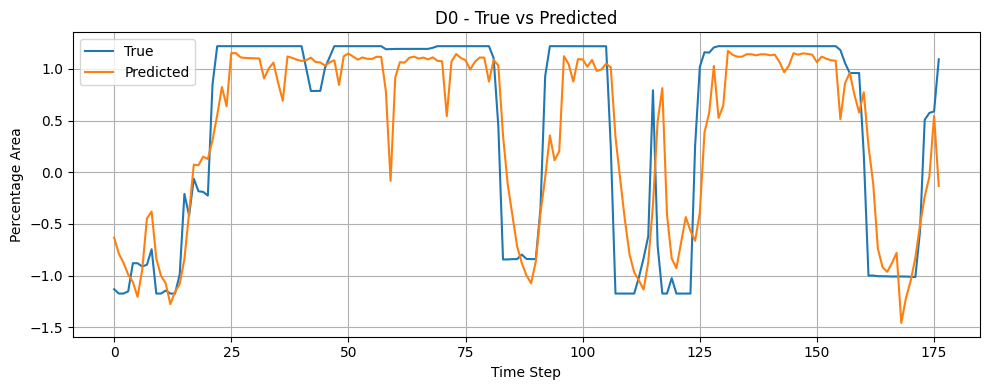

D1 - MAE: 0.3273, R²: 0.7906


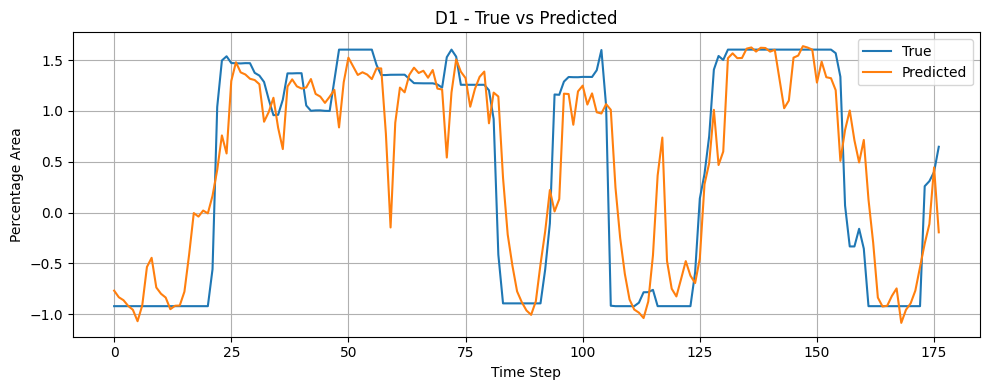

D2 - MAE: 0.4611, R²: 0.7187


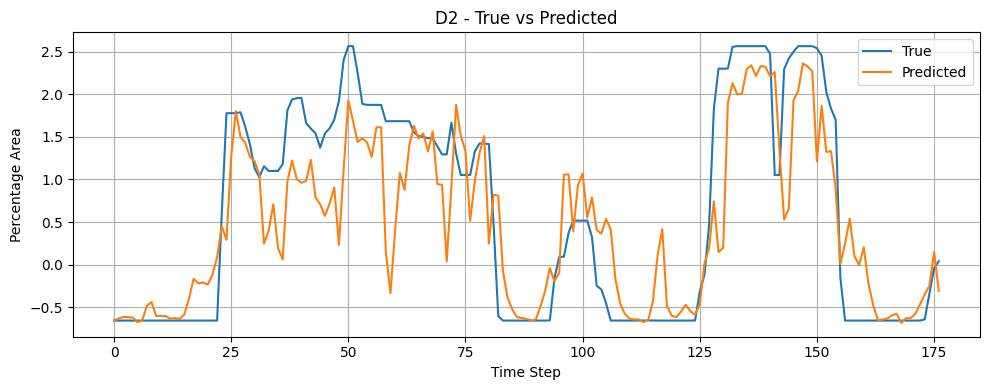

D3 - MAE: 0.6675, R²: 0.3734


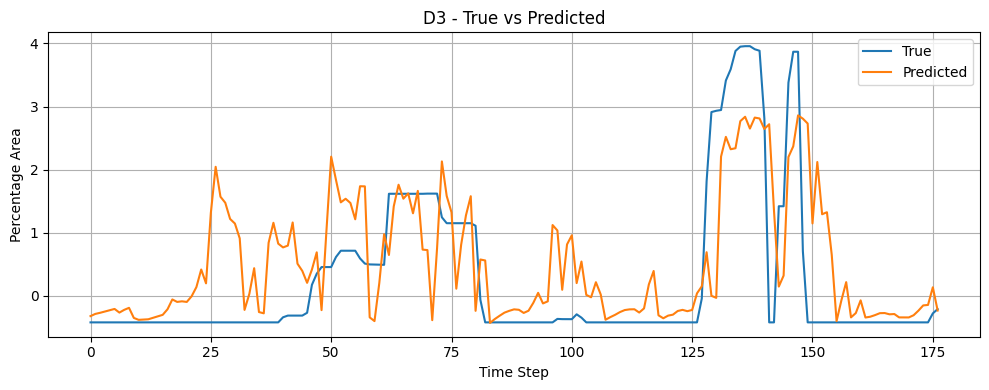

D4 - MAE: 0.4521, R²: -0.2149


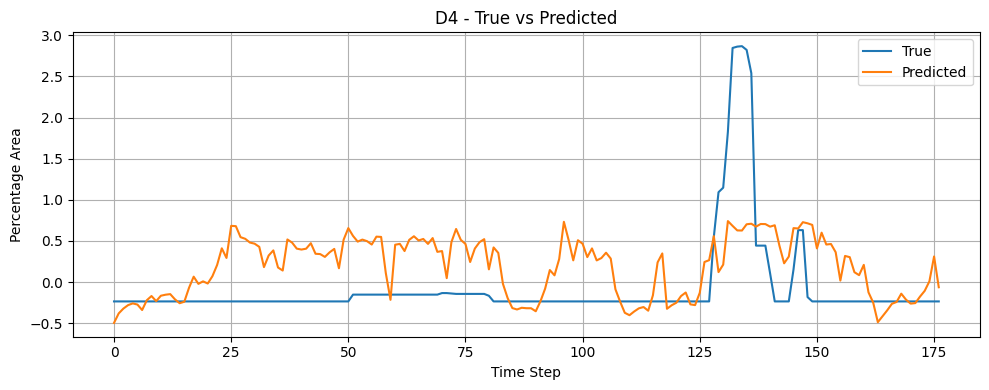

In [169]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Step 1: Preprocessing and Feature Engineering
# Assuming final_historical_df is your dataframe
final_historical_df['date'] = pd.to_datetime(final_historical_df['date'])

# Create Lag Features (1-step lag for D0, D1, D2, D3, D4)
for col in ['D0', 'D1', 'D2', 'D3', 'D4']:
    for lag in range(1, 4):  # Lag 1, 2, 3
        final_historical_df[f'{col}_lag{lag}'] = final_historical_df[col].shift(lag)

# Create Rolling Mean and Std Features (using a window of 7 days, for example)
for col in ['D0', 'D1', 'D2', 'D3', 'D4']:
    final_historical_df[f'{col}_rolling_mean'] = final_historical_df[col].rolling(window=7).mean()
    final_historical_df[f'{col}_rolling_std'] = final_historical_df[col].rolling(window=7).std()

# Drop NaN values generated by shifting and rolling operations
final_historical_df = final_historical_df.dropna()

# Step 2: Prepare Features and Targets
features = final_historical_df.drop(columns=['date', 'D0', 'D1', 'D2', 'D3', 'D4'])
target = final_historical_df[['D0', 'D1', 'D2', 'D3', 'D4']]

# Normalize Features and Targets
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X_scaled = feature_scaler.fit_transform(features)
y_scaled = target_scaler.fit_transform(target)

# Step 3: Create Sequences for LSTM
SEQ_LENGTH = 12 # 12 time steps (e.g., 12 weeks of data)
# 12 = all r^2 are above 0 (d3,4 improved)


X_seq, y_seq = [], []
for i in range(len(X_scaled) - SEQ_LENGTH):
    X_seq.append(X_scaled[i:i+SEQ_LENGTH])  # Sequence of features
    y_seq.append(y_scaled[i+SEQ_LENGTH])  # Next time step prediction

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# Step 4: Train/Test Split
split_idx = int(0.8 * len(X_seq))  # 80% train, 20% test
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

# Step 5: Build and Train the LSTM Model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQ_LENGTH, X_train.shape[2])),
    Dropout(0.3),
    LSTM(32),
    Dense(5)  # Output size matches D0, D1, D2, D3, D4
])

learning_rate = 0.05
# Compile the model with the custom learning rate
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=32,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

# Step 6: Evaluate the Model
y_pred_scaled = model.predict(X_test)

# Inverse transform predictions and true labels to original scale
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_orig = target_scaler.inverse_transform(y_test)

# Calculate MAE and R² for each drought level
from sklearn.metrics import mean_absolute_error, r2_score

for i, category in enumerate(['D0', 'D1', 'D2', 'D3', 'D4']):
    mae = mean_absolute_error(y_test_orig[:, i], y_pred[:, i])
    r2 = r2_score(y_test_orig[:, i], y_pred[:, i])
    print(f"{category} - MAE: {mae:.4f}, R²: {r2:.4f}")
    
    # Plot predictions vs true values
    plt.figure(figsize=(10, 4))
    plt.plot(y_test_orig[:, i], label='True')
    plt.plot(y_pred[:, i], label='Predicted')
    plt.title(f"{category} - True vs Predicted")
    plt.xlabel("Time Step")
    plt.ylabel("Percentage Area")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Random Forest and XgBoost


====== RandomForest Results ======
D0 - MAE: 0.2078, R²: 0.8724


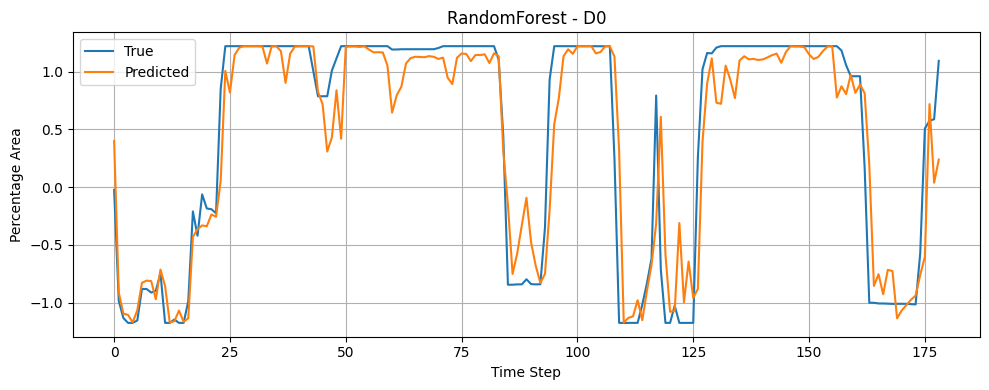

D1 - MAE: 0.2007, R²: 0.8965


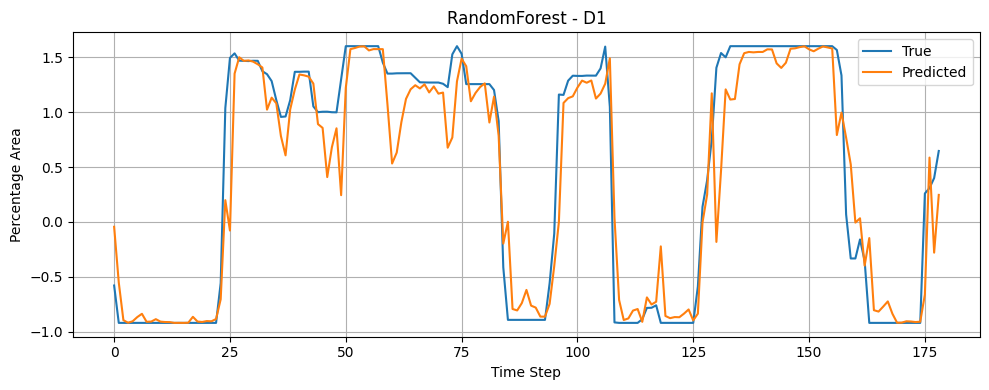

D2 - MAE: 0.2233, R²: 0.9008


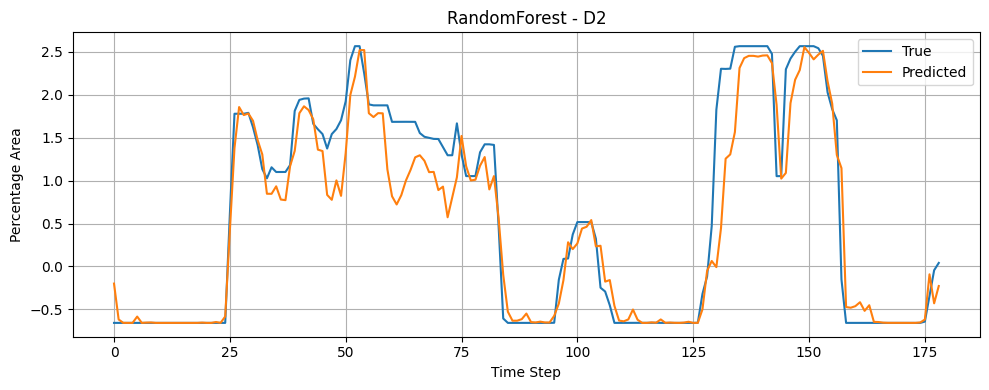

D3 - MAE: 0.2838, R²: 0.7271


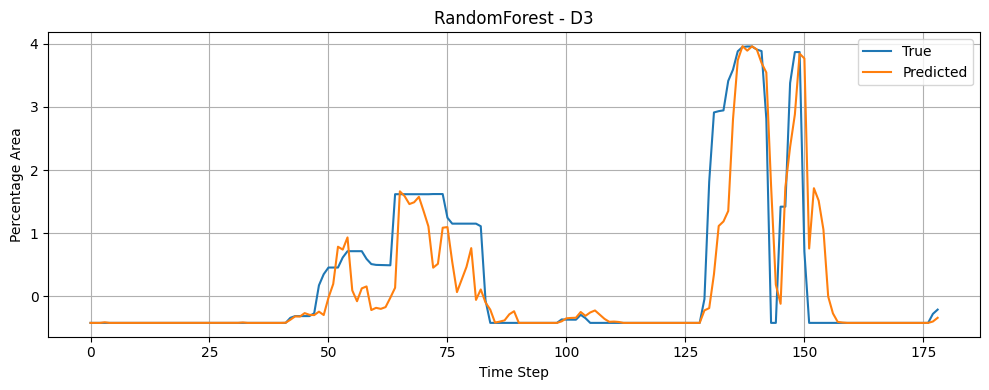

D4 - MAE: 0.1138, R²: 0.5707


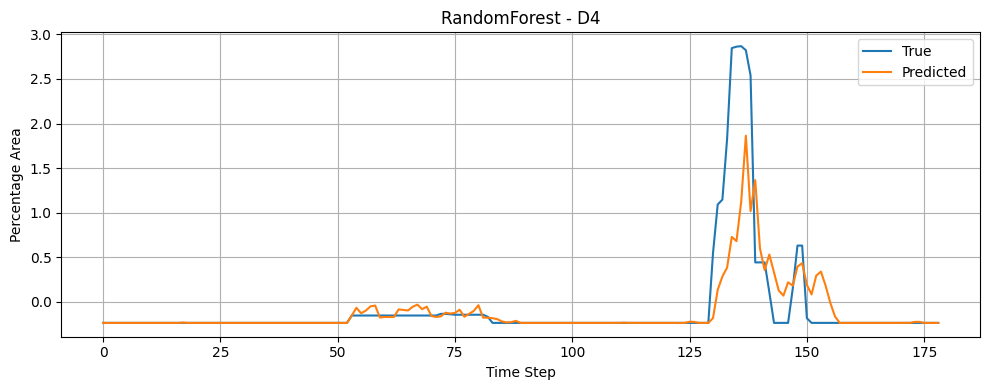


====== XGBoost Results ======
D0 - MAE: 0.2301, R²: 0.8547


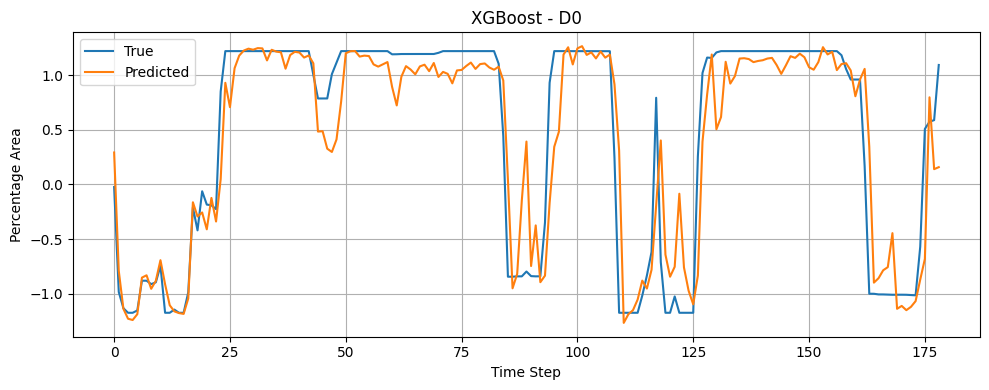

D1 - MAE: 0.2361, R²: 0.8679


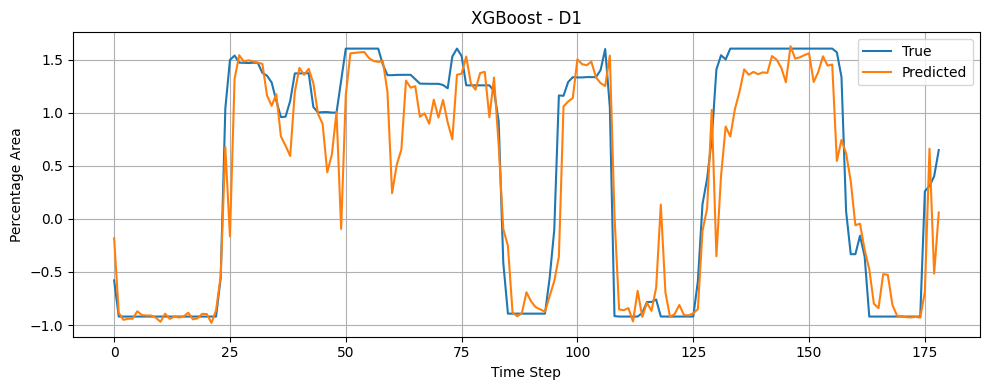

D2 - MAE: 0.2779, R²: 0.8397


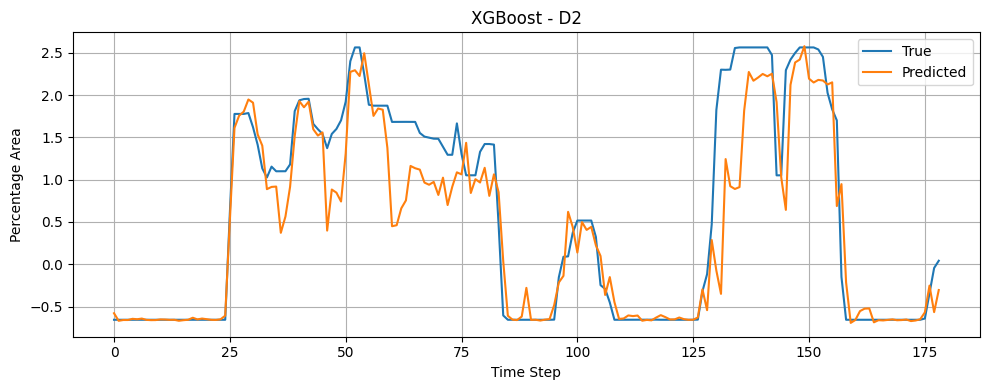

D3 - MAE: 0.3170, R²: 0.6558


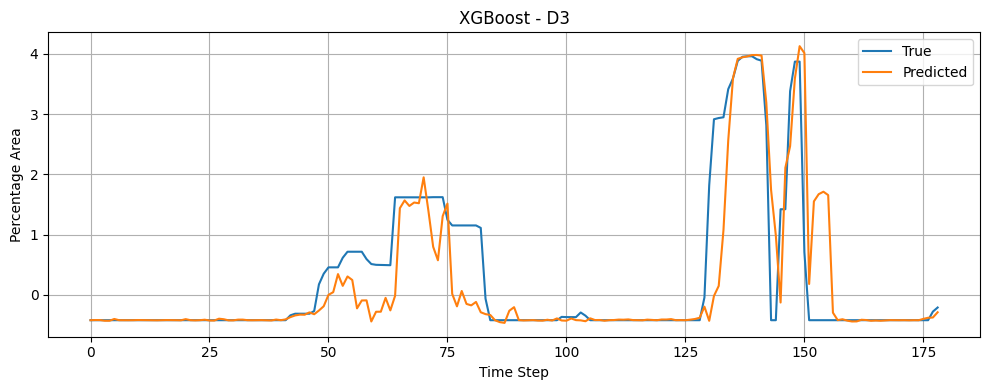

D4 - MAE: 0.1507, R²: 0.1483


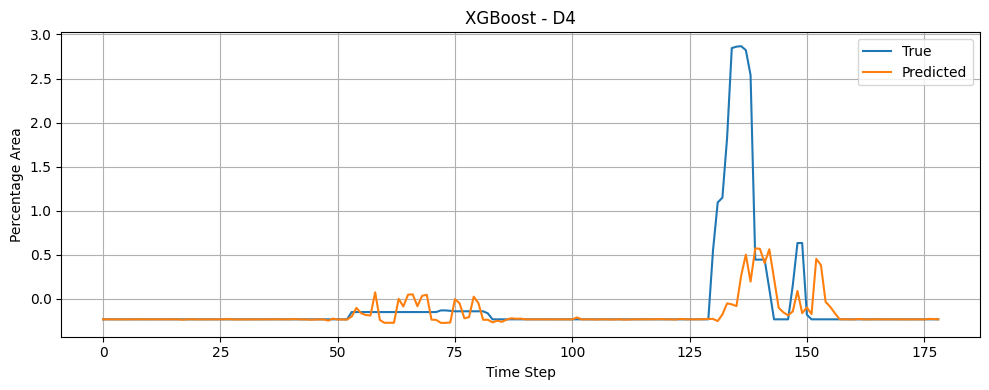

In [168]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Step 1: Feature Engineering
df = final_historical_df.copy()
df['date'] = pd.to_datetime(df['date'])

# Create lag features
for col in ['D0', 'D1', 'D2', 'D3', 'D4']:
    for lag in range(1, 4):
        df[f'{col}_lag{lag}'] = df[col].shift(lag)

# Create rolling stats (7-day window)
for col in ['D0', 'D1', 'D2', 'D3', 'D4']:
    df[f'{col}_roll_mean'] = df[col].rolling(window=7).mean()
    df[f'{col}_roll_std'] = df[col].rolling(window=7).std()

# Drop NaNs caused by lag and rolling
df = df.dropna().reset_index(drop=True)

# Step 2: Features and Targets
X = df.drop(columns=['date', 'D0', 'D1', 'D2', 'D3', 'D4'])
y = df[['D0', 'D1', 'D2', 'D3', 'D4']]

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Time-aware split (80% train, 20% test)
split_idx = int(0.8 * len(X))
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y[:split_idx].values, y[split_idx:].values

# Step 3: Fit and Evaluate Models
results = {}

for model_name, model_class in {
    'RandomForest': RandomForestRegressor,
    'XGBoost': XGBRegressor
}.items():
    
    print(f"\n====== {model_name} Results ======")
    model_results = {}
    
    for i, target in enumerate(['D0', 'D1', 'D2', 'D3', 'D4']):
        model = model_class(n_estimators=100, random_state=42)
        model.fit(X_train, y_train[:, i])
        y_pred = model.predict(X_test)
        
        mae = mean_absolute_error(y_test[:, i], y_pred)
        r2 = r2_score(y_test[:, i], y_pred)
        model_results[target] = {'MAE': mae, 'R2': r2}
        
        print(f"{target} - MAE: {mae:.4f}, R²: {r2:.4f}")
        
        # Plot predictions
        plt.figure(figsize=(10, 4))
        plt.plot(y_test[:, i], label='True')
        plt.plot(y_pred, label='Predicted')
        plt.title(f"{model_name} - {target}")
        plt.xlabel("Time Step")
        plt.ylabel("Percentage Area")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
    results[model_name] = model_results


In [172]:
!pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.6 MB/s eta 0:00:00a 0:00:01



--- D0 ---

RandomForest:
MAE: 0.2064, R^2: 0.8690


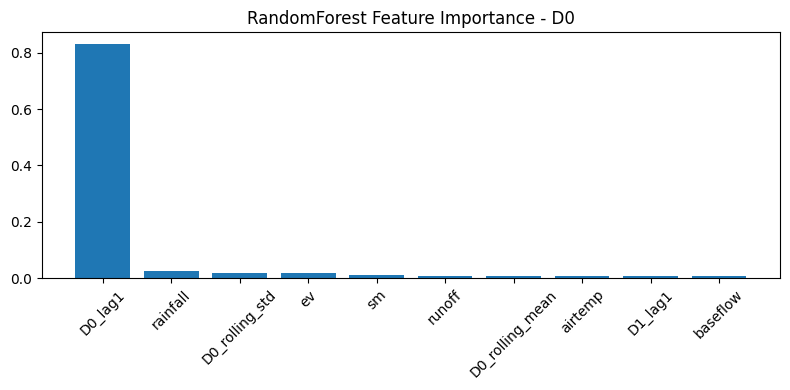


XGBoost:
MAE: 0.2202, R^2: 0.8555


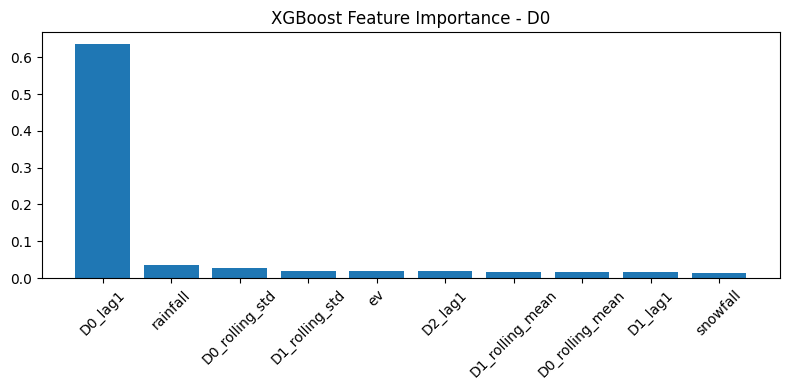


--- D1 ---

RandomForest:
MAE: 0.2030, R^2: 0.8883


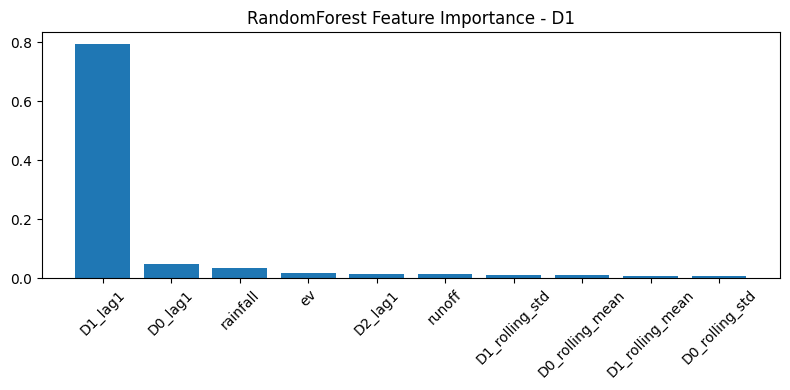


XGBoost:
MAE: 0.2217, R^2: 0.8792


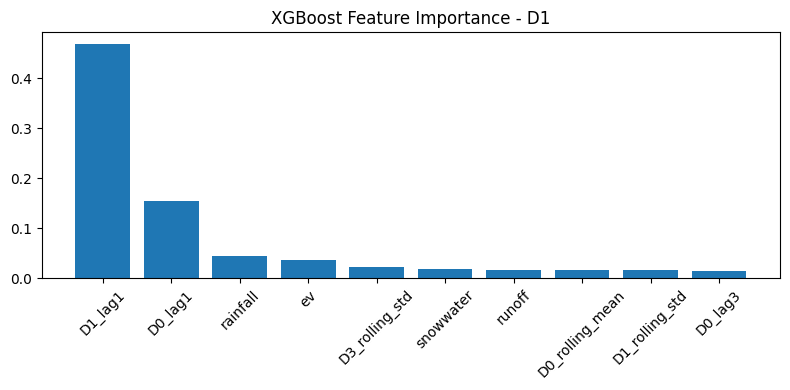


--- D2 ---

RandomForest:
MAE: 0.2401, R^2: 0.8971


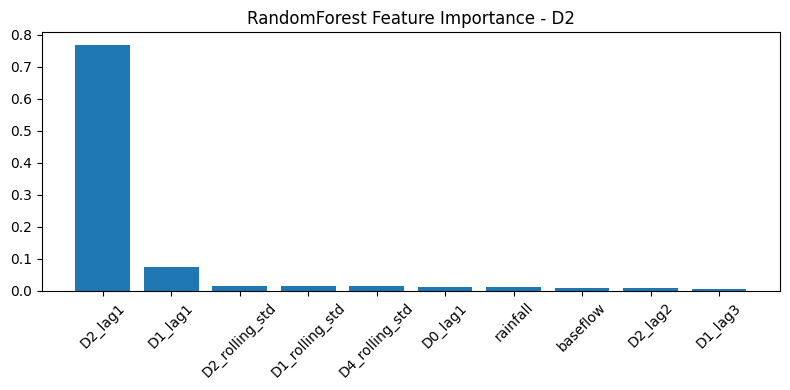


XGBoost:
MAE: 0.2907, R^2: 0.8611


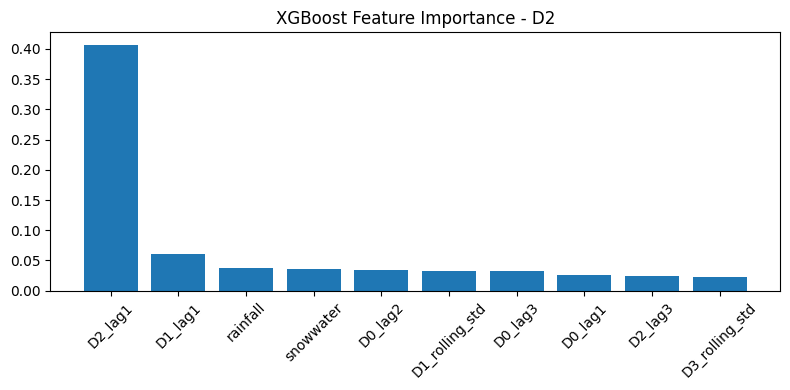


--- D3 ---

RandomForest:
MAE: 0.2693, R^2: 0.7639


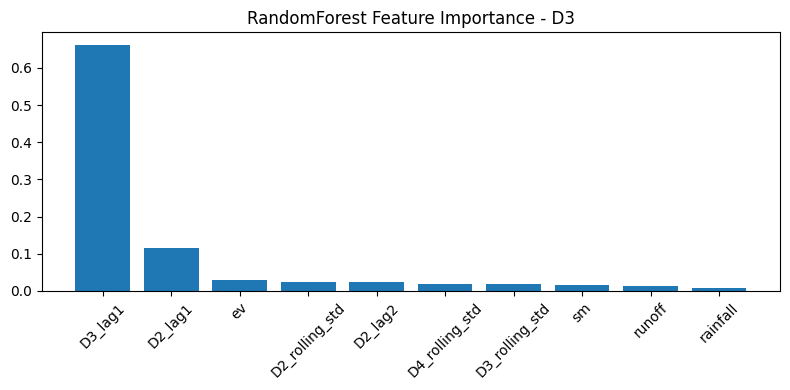


XGBoost:
MAE: 0.3299, R^2: 0.6143


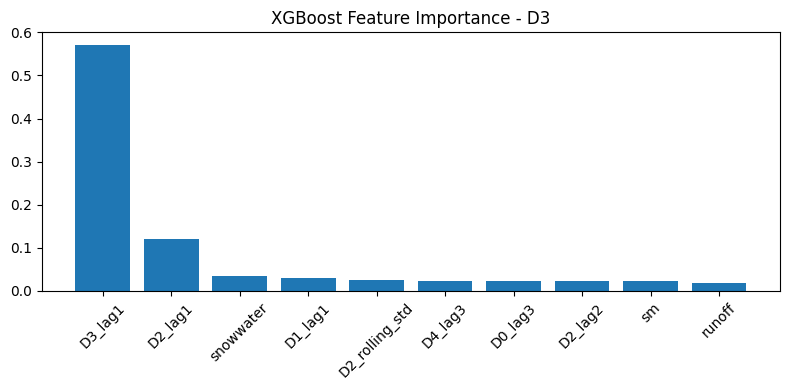


--- D4 ---

RandomForest:
MAE: 0.1250, R^2: 0.5514


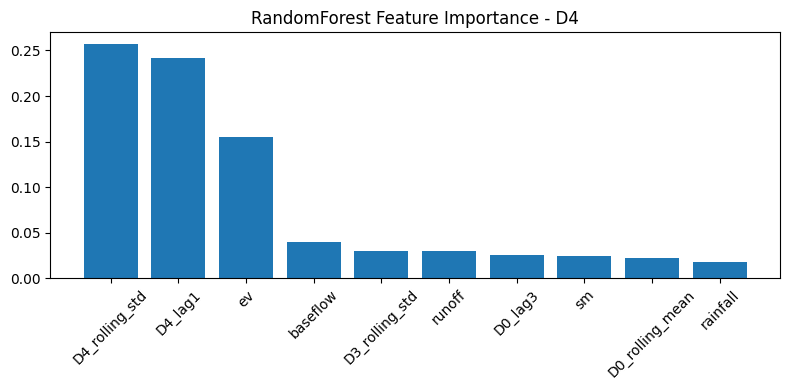


XGBoost:
MAE: 0.1571, R^2: 0.1491


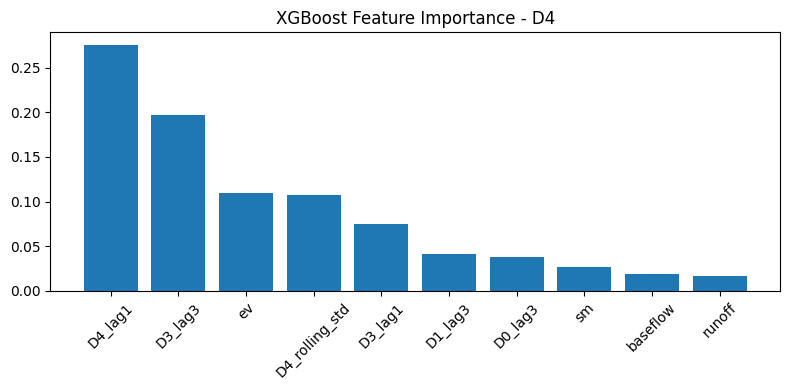


LightGBM - D0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4845
[LightGBM] [Info] Number of data points in the train set: 705, number of used features: 33
[LightGBM] [Info] Start training from score -0.094997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


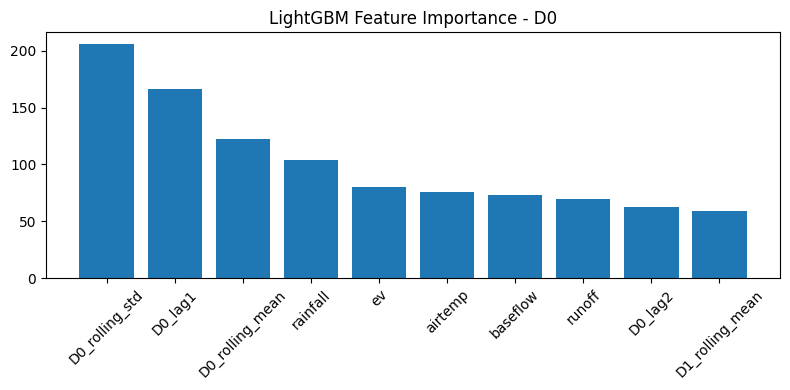


LightGBM - D1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4845
[LightGBM] [Info] Number of data points in the train set: 705, number of used features: 33
[LightGBM] [Info] Start training from score -0.098113
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


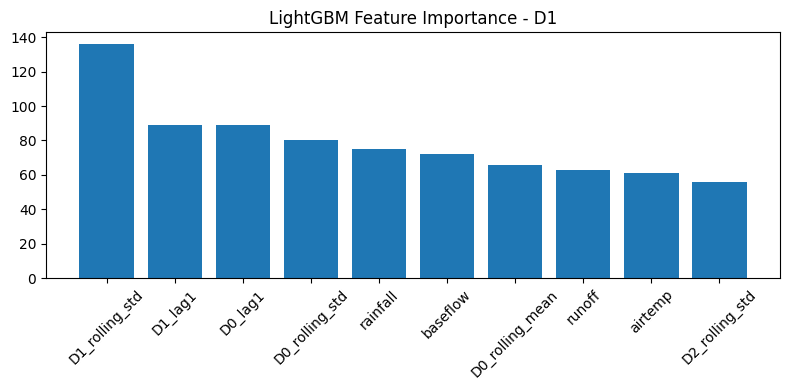


LightGBM - D2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4845
[LightGBM] [Info] Number of data points in the train set: 705, number of used features: 33
[LightGBM] [Info] Start training from score -0.123395
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


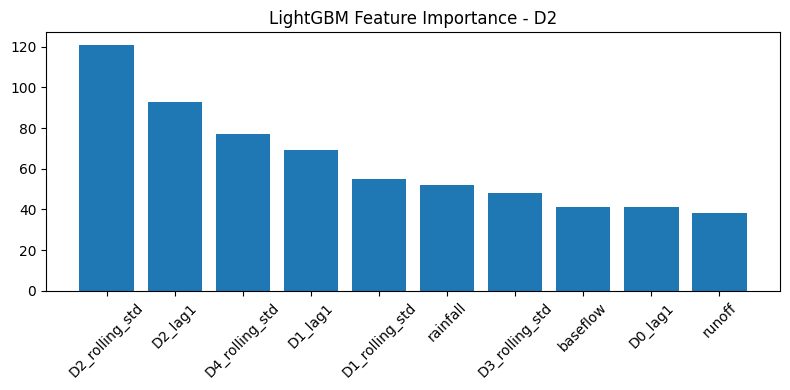


LightGBM - D3
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4845
[LightGBM] [Info] Number of data points in the train set: 705, number of used features: 33
[LightGBM] [Info] Start training from score -0.055960
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


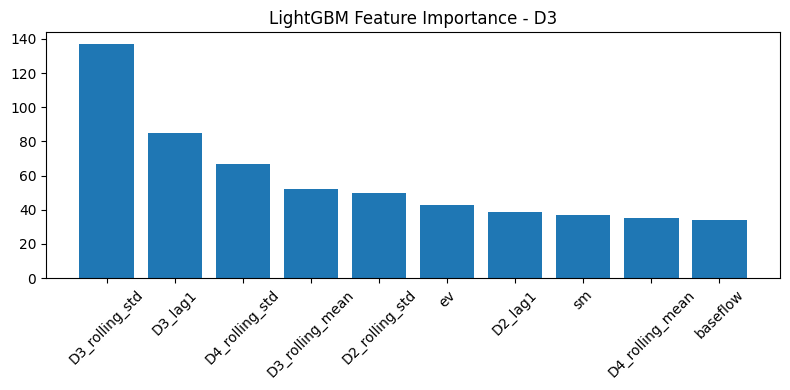


LightGBM - D4
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4845
[LightGBM] [Info] Number of data points in the train set: 705, number of used features: 33
[LightGBM] [Info] Start training from score -0.012134
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

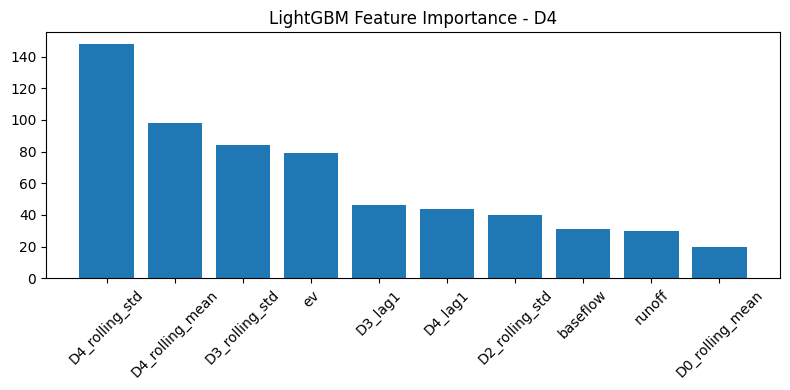

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0899 - mae: 0.1896 - val_loss: 0.0985 - val_mae: 0.2287
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0610 - mae: 0.1705 - val_loss: 0.0845 - val_mae: 0.1993
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0565 - mae: 0.1609 - val_loss: 0.0717 - val_mae: 0.1850
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0485 - mae: 0.1475 - val_loss: 0.0655 - val_mae: 0.1704
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0412 - mae: 0.1327 - val_loss: 0.0606 - val_mae: 0.1706
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0428 - mae: 0.1382 - val_loss: 0.0611 - val_mae: 0.1663
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0342 - mae: 0.1239 - val_loss: 0.0544 - val_mae: 0.1630
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0388 - mae: 0.1321 - val_loss: 0.0603 - val_mae: 0.1681
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0316 - mae: 

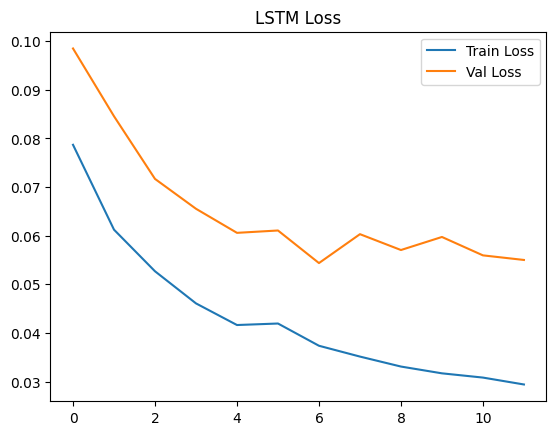

In [173]:
# Full pipeline: Drought prediction using Random Forest, XGBoost, LSTM (with tuning) and LightGBM per drought level

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# ---------- Data Preprocessing ----------
final_historical_df['date'] = pd.to_datetime(final_historical_df['date'])

# Create lag features and rolling stats
for col in ['D0', 'D1', 'D2', 'D3', 'D4']:
    for lag in range(1, 4):
        final_historical_df[f'{col}_lag{lag}'] = final_historical_df[col].shift(lag)
    final_historical_df[f'{col}_rolling_mean'] = final_historical_df[col].rolling(window=7).mean()
    final_historical_df[f'{col}_rolling_std'] = final_historical_df[col].rolling(window=7).std()

final_historical_df = final_historical_df.dropna()

# Feature/target split
features = final_historical_df.drop(columns=['date', 'D0', 'D1', 'D2', 'D3', 'D4'])
targets = final_historical_df[['D0', 'D1', 'D2', 'D3', 'D4']]

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    features, targets, test_size=0.2, shuffle=False
)

# Normalize features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test_full)

# ---------- Random Forest & XGBoost (with Grid Search & Feature Importance) ----------
models = {
    'RandomForest': RandomForestRegressor(),
    'XGBoost': XGBRegressor(objective='reg:squarederror')
}

param_grids = {
    'RandomForest': {
        'n_estimators': [50, 100],
        'max_depth': [5, 10]
    },
    'XGBoost': {
        'n_estimators': [50, 100],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 6]
    }
}

tscv = TimeSeriesSplit(n_splits=3)

for drought_level in ['D0', 'D1', 'D2', 'D3', 'D4']:
    print(f"\n--- {drought_level} ---")
    y_train = y_train_full[drought_level]
    y_test = y_test_full[drought_level]

    for name, model in models.items():
        print(f"\n{name}:")
        gsearch = GridSearchCV(model, param_grids[name], cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1)
        gsearch.fit(X_train_scaled, y_train)
        best_model = gsearch.best_estimator_

        y_pred = best_model.predict(X_test_scaled)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        print(f"MAE: {mae:.4f}, R^2: {r2:.4f}")

        importances = best_model.feature_importances_
        sorted_idx = np.argsort(importances)[::-1][:10]
        plt.figure(figsize=(8, 4))
        plt.bar(np.array(features.columns)[sorted_idx], importances[sorted_idx])
        plt.title(f'{name} Feature Importance - {drought_level}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# ---------- LightGBM (Trained Separately Per D Level) ----------
for drought_level in ['D0', 'D1', 'D2', 'D3', 'D4']:
    print(f"\nLightGBM - {drought_level}")
    y_train = y_train_full[drought_level]
    y_test = y_test_full[drought_level]

    lgb_model = LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=6)
    lgb_model.fit(X_train_scaled, y_train)
    y_pred = lgb_model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"MAE: {mae:.4f}, R^2: {r2:.4f}")

    importances = lgb_model.feature_importances_
    sorted_idx = np.argsort(importances)[::-1][:10]
    plt.figure(figsize=(8, 4))
    plt.bar(np.array(features.columns)[sorted_idx], importances[sorted_idx])
    plt.title(f'LightGBM Feature Importance - {drought_level}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# ---------- LSTM (with Feature Selection if Desired) ----------
# We use the same preprocessing from before to create sequences
SEQ_LENGTH = 12
X_seq, y_seq = [], []

# Multivariate output for LSTM
scaled_targets = MinMaxScaler().fit_transform(y_train_full)

for i in range(len(X_train_scaled) - SEQ_LENGTH):
    X_seq.append(X_train_scaled[i:i+SEQ_LENGTH])
    y_seq.append(scaled_targets[i+SEQ_LENGTH])

X_seq, y_seq = np.array(X_seq), np.array(y_seq)

X_train_lstm, X_val_lstm = X_seq[:-100], X_seq[-100:]
y_train_lstm, y_val_lstm = y_seq[:-100], y_seq[-100:]

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQ_LENGTH, X_seq.shape[2])),
    Dropout(0.3),
    LSTM(32),
    Dense(5)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_val_lstm, y_val_lstm),
    epochs=100,
    batch_size=32,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('LSTM Loss')
plt.legend()
plt.show()


## Cross Validation for all models


--- D0 ---

Random Forest - D0 - Cross-Validation Results:
R² Mean: 0.8782, Std: 0.0124
MSE Mean: 0.0215, Std: -0.0027
MAE Mean: 0.0828, Std: -0.0030


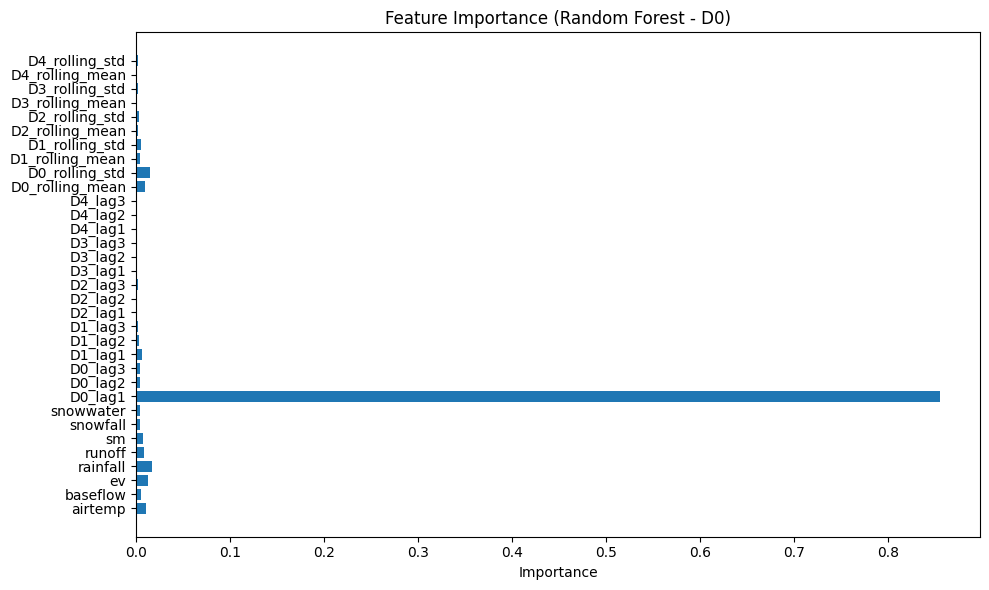


--- D1 ---

Random Forest - D1 - Cross-Validation Results:
R² Mean: 0.8788, Std: 0.0196
MSE Mean: 0.0195, Std: -0.0026
MAE Mean: 0.0782, Std: -0.0045


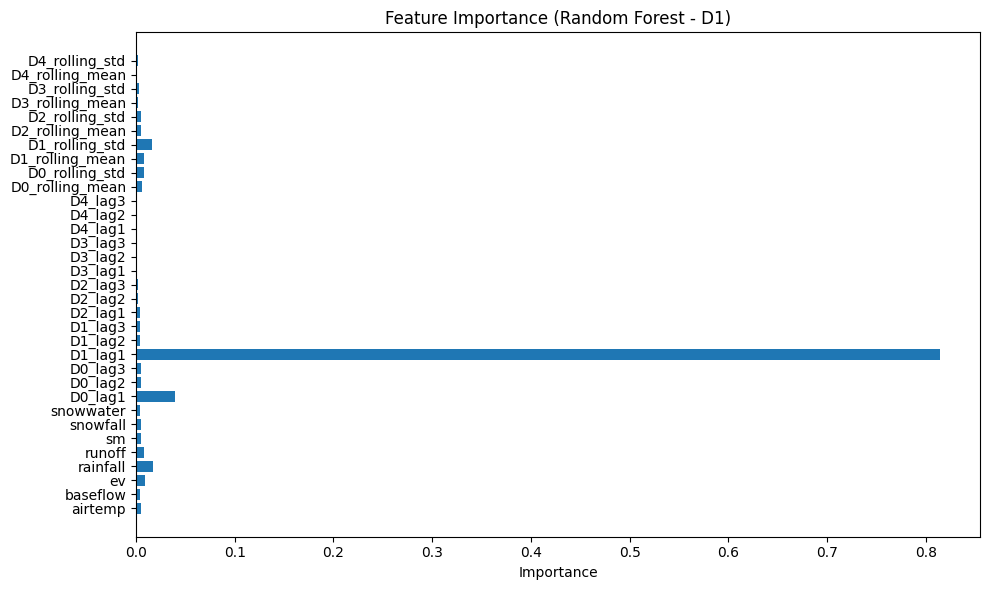


--- D2 ---

Random Forest - D2 - Cross-Validation Results:
R² Mean: 0.8775, Std: 0.0454
MSE Mean: 0.0119, Std: -0.0037
MAE Mean: 0.0554, Std: -0.0063


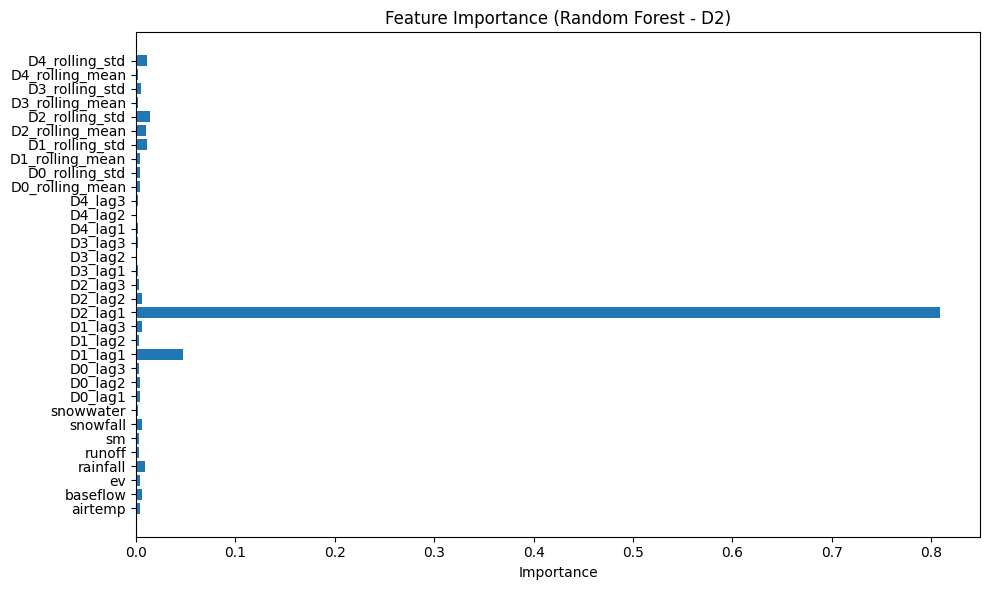


--- D3 ---

Random Forest - D3 - Cross-Validation Results:
R² Mean: 0.8211, Std: 0.0400
MSE Mean: 0.0090, Std: -0.0024
MAE Mean: 0.0374, Std: -0.0056


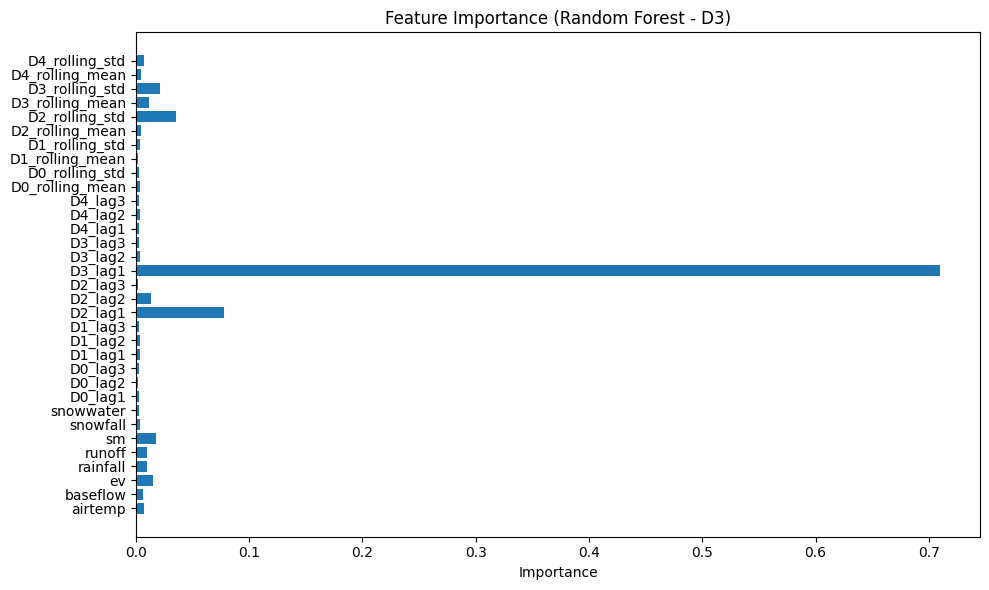


--- D4 ---

Random Forest - D4 - Cross-Validation Results:
R² Mean: 0.4560, Std: 0.1373
MSE Mean: 0.0042, Std: -0.0015
MAE Mean: 0.0182, Std: -0.0037


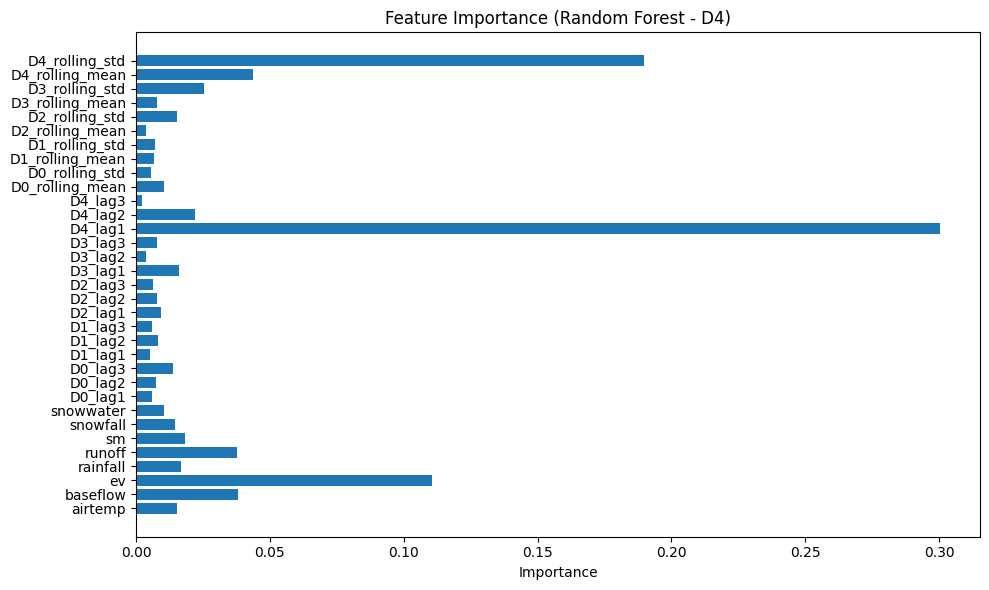


--- D0 ---

XGBoost - D0 - Cross-Validation Results:
R² Mean: 0.8652, Std: 0.0168
MSE Mean: 0.0238, Std: -0.0031
MAE Mean: 0.0877, Std: -0.0028


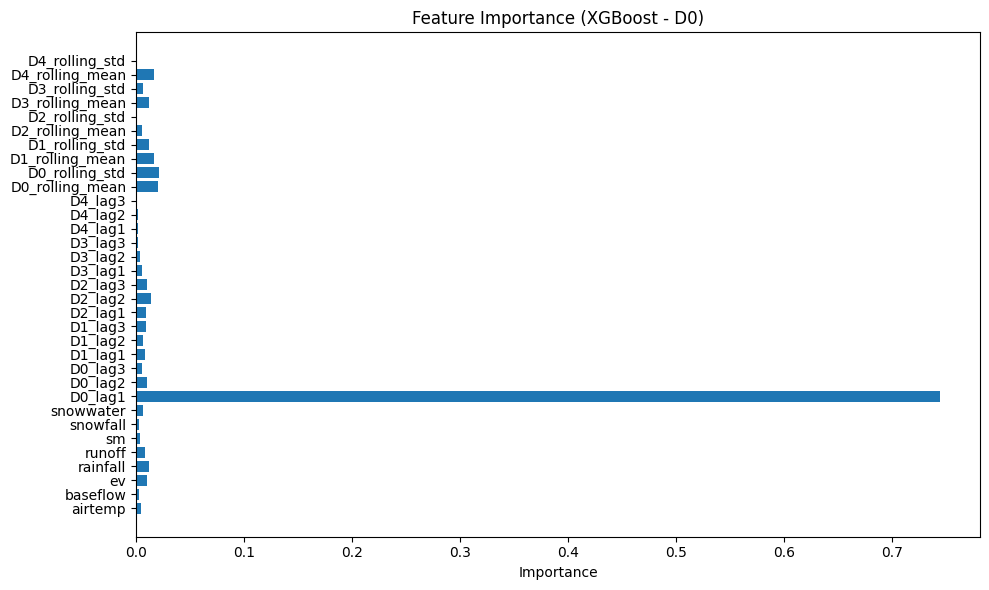


--- D1 ---

XGBoost - D1 - Cross-Validation Results:
R² Mean: 0.8654, Std: 0.0246
MSE Mean: 0.0216, Std: -0.0032
MAE Mean: 0.0831, Std: -0.0057


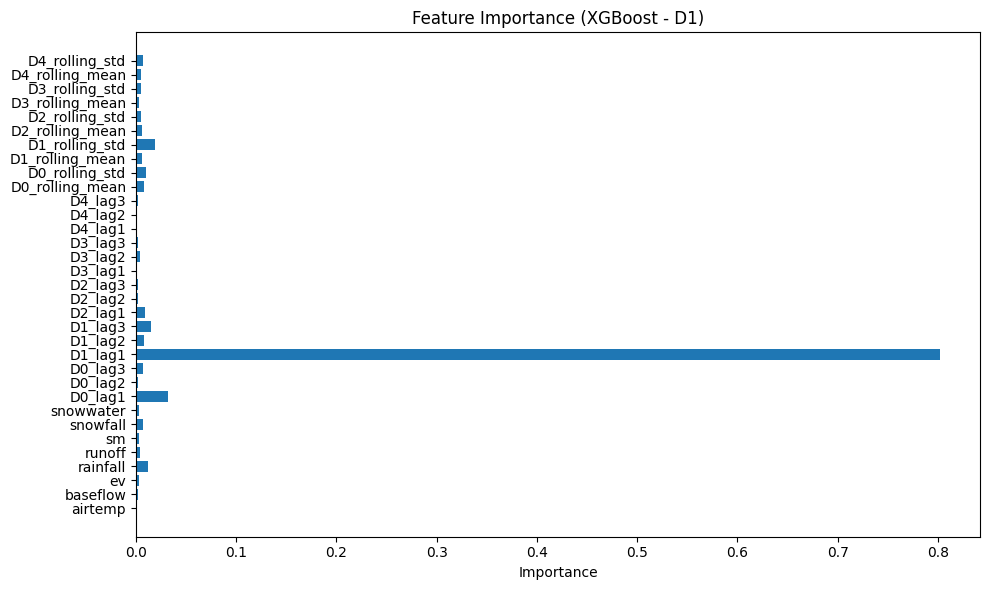


--- D2 ---

XGBoost - D2 - Cross-Validation Results:
R² Mean: 0.8672, Std: 0.0412
MSE Mean: 0.0130, Std: -0.0034
MAE Mean: 0.0568, Std: -0.0074


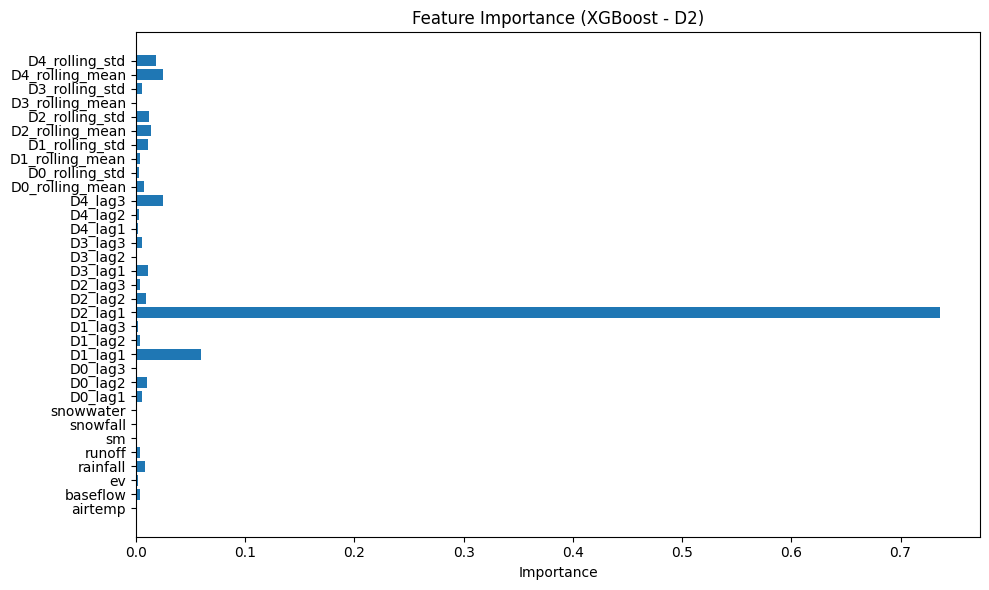


--- D3 ---

XGBoost - D3 - Cross-Validation Results:
R² Mean: 0.8200, Std: 0.0534
MSE Mean: 0.0092, Std: -0.0034
MAE Mean: 0.0368, Std: -0.0069


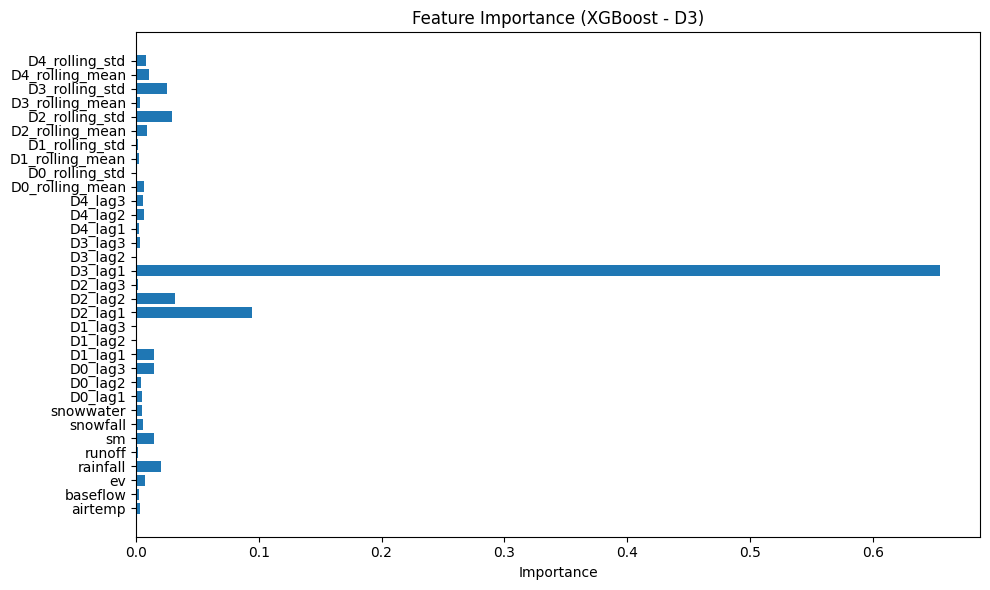


--- D4 ---

XGBoost - D4 - Cross-Validation Results:
R² Mean: 0.3633, Std: 0.1823
MSE Mean: 0.0049, Std: -0.0018
MAE Mean: 0.0181, Std: -0.0056


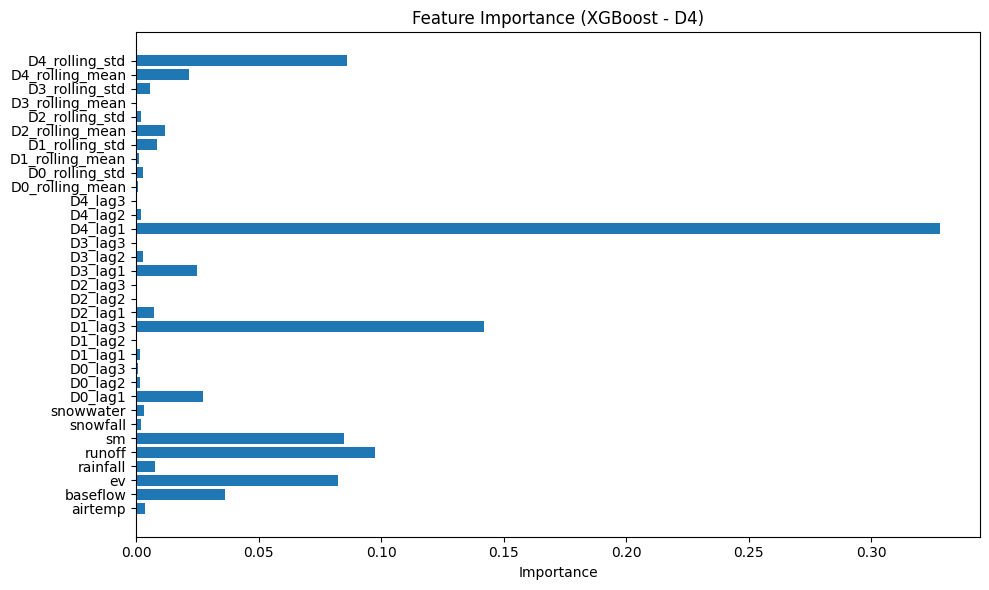


--- D0 ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5895
[LightGBM] [Info] Number of data points in the train set: 882, number of used features: 33
[LightGBM] [Info] Start training from score 0.496811
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4950
[LightGBM] [Info] Number of data points in the train set: 705, number of used features: 33
[LightGBM] [Info] Start training from score 0.507578
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


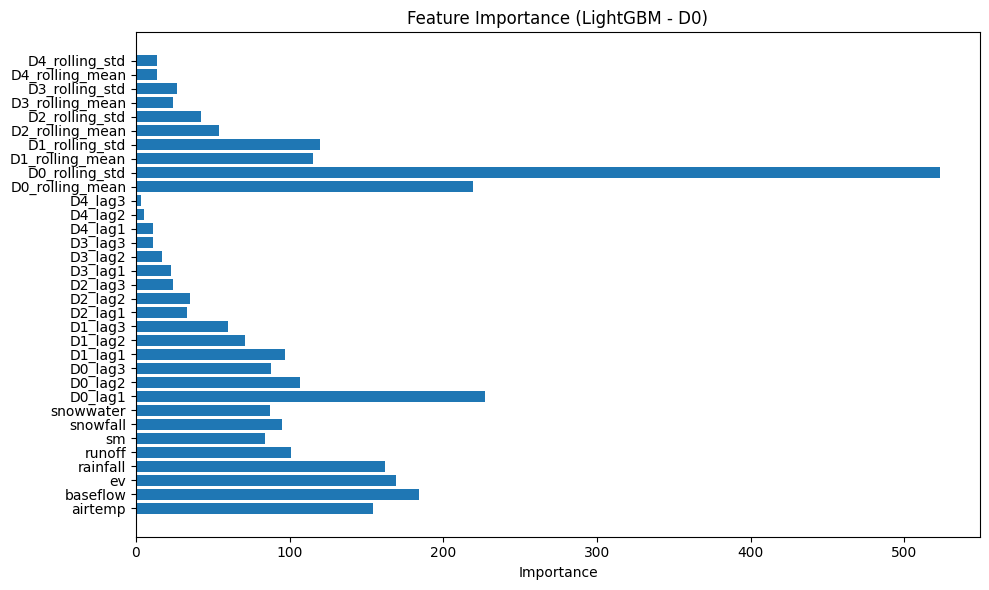


--- D1 ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5895
[LightGBM] [Info] Number of data points in the train set: 882, number of used features: 33
[LightGBM] [Info] Start training from score 0.371554
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4950
[LightGBM] [Info] Number of data points in the train set: 705, number of used features: 33
[LightGBM] [Info] Start training from score 0.378530
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


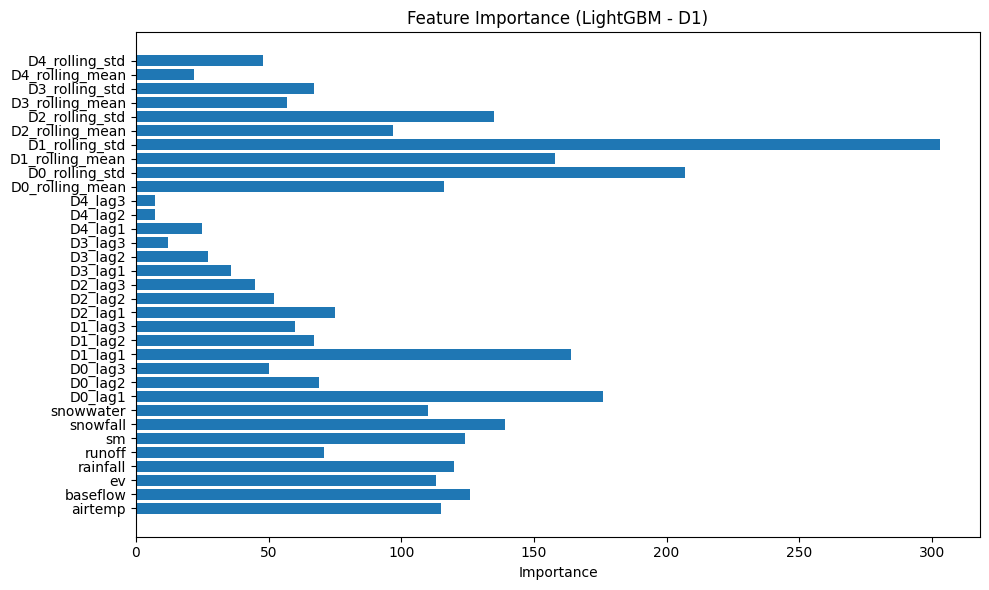


--- D2 ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5895
[LightGBM] [Info] Number of data points in the train set: 882, number of used features: 33
[LightGBM] [Info] Start training from score 0.211289
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4950
[LightGBM] [Info] Number of data points in the train set: 705, number of used features: 33
[LightGBM] [Info] Start training from score 0.214245
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


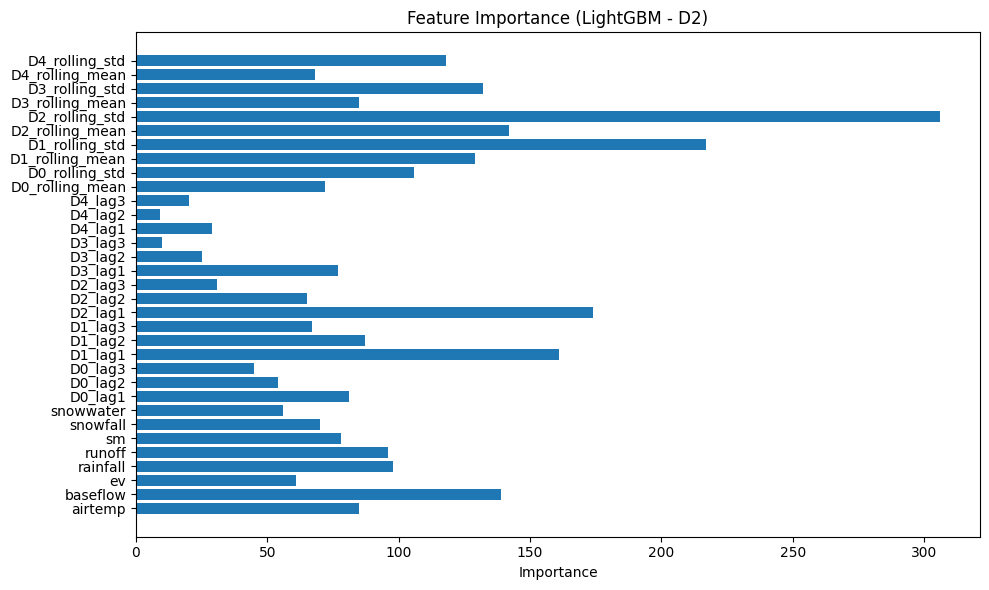


--- D3 ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000661 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5895
[LightGBM] [Info] Number of data points in the train set: 882, number of used features: 33
[LightGBM] [Info] Start training from score 0.092585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4950
[LightGBM] [Info] Number

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4864
[LightGBM] [Info] Number of data points in the train set: 705, number of used features: 33
[LightGBM] [Info] Start training from score 0.093294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4932
[LightGBM] [Info] Number of data points in the train set: 706, number of used features: 33
[LightGBM] [Info] Start training from score 0.098380
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


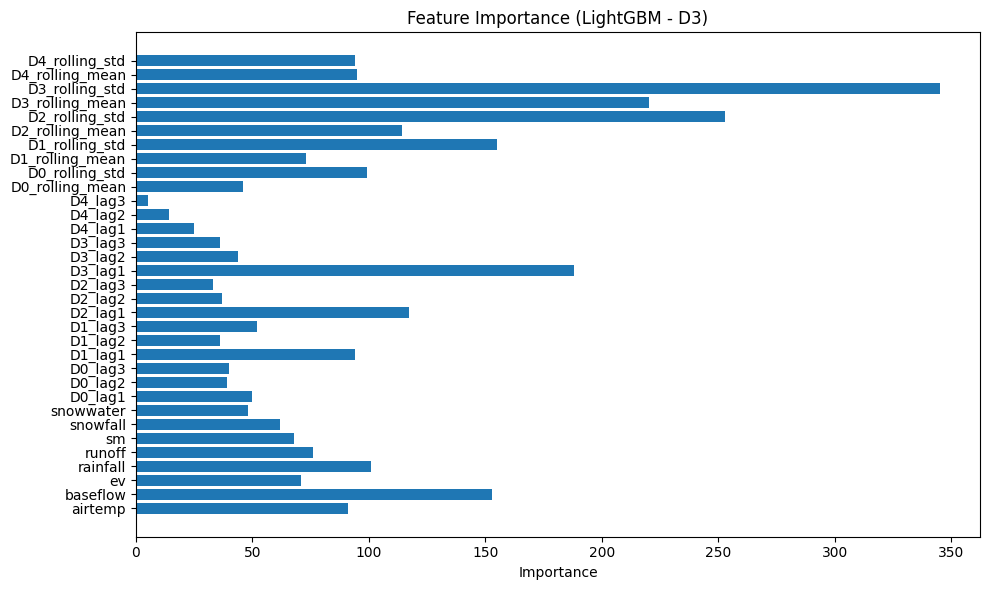


--- D4 ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5895
[LightGBM] [Info] Number of data points in the train set: 882, number of used features: 33
[LightGBM] [Info] Start training from score 0.020102
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


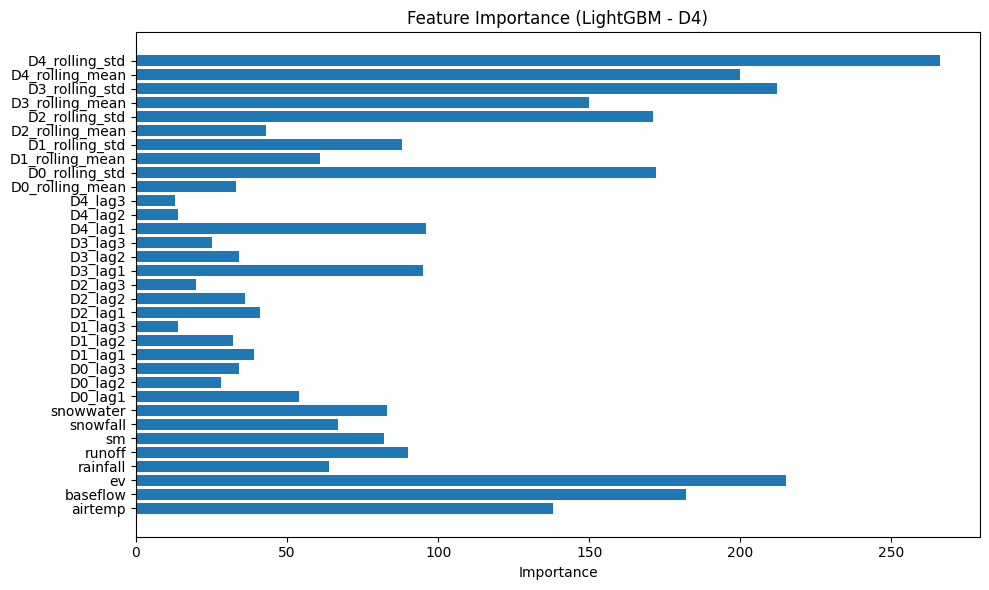

In [177]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming final_historical_df is already preprocessed and contains features like lag and rolling stats

# Prepare the features and target variables
features = final_historical_df.drop(columns=['date', 'D0', 'D1', 'D2', 'D3', 'D4'])
target = final_historical_df[['D0', 'D1', 'D2', 'D3', 'D4']]

# Normalize the features and targets
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X_scaled = feature_scaler.fit_transform(features)
y_scaled = target_scaler.fit_transform(target)

# Convert y_scaled to a DataFrame for easier indexing by column names
y_scaled_df = pd.DataFrame(y_scaled, columns=['D0', 'D1', 'D2', 'D3', 'D4'])

# Function to evaluate and print metrics for each model
def evaluate_model(model, X, y, label='Model'):
    # Train the model before evaluating
    model.fit(X, y)
    
    # Perform cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    scores_r2 = cross_val_score(model, X, y, cv=kfold, scoring='r2')
    scores_mse = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_squared_error')
    scores_mae = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_absolute_error')

    print(f"\n{label} - Cross-Validation Results:")
    print(f"R² Mean: {scores_r2.mean():.4f}, Std: {scores_r2.std():.4f}")
    print(f"MSE Mean: {-scores_mse.mean():.4f}, Std: {-scores_mse.std():.4f}")
    print(f"MAE Mean: {-scores_mae.mean():.4f}, Std: {-scores_mae.std():.4f}")

    # Plot feature importances (for Random Forest, XGBoost, LightGBM)
    if hasattr(model, 'feature_importances_'):
        feature_importances = model.feature_importances_
    elif hasattr(model, 'get_booster'):
        feature_importances = model.get_booster().get_score(importance_type='weight')
    else:
        feature_importances = None
    
    if feature_importances is not None:
        plt.figure(figsize=(10, 6))
        if isinstance(feature_importances, np.ndarray):  # For Random Forest
            plt.barh(range(len(feature_importances)), feature_importances)
            plt.yticks(range(len(feature_importances)), features.columns)
        else:  # For XGBoost or LightGBM
            importance_scores = [feature_importances.get(f"f{i}", 0) for i in range(len(features.columns))]
            plt.barh(range(len(importance_scores)), importance_scores)
            plt.yticks(range(len(importance_scores)), features.columns)
        
        plt.title(f"Feature Importance ({label})")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Perform cross-validation for each drought level
for drought_level in ['D0', 'D1', 'D2', 'D3', 'D4']:
    print(f"\n--- {drought_level} ---")
    y_drought = y_scaled_df[drought_level]
    evaluate_model(rf_model, X_scaled, y_drought, label=f"Random Forest - {drought_level}")

# Train XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

for drought_level in ['D0', 'D1', 'D2', 'D3', 'D4']:
    print(f"\n--- {drought_level} ---")
    y_drought = y_scaled_df[drought_level]
    evaluate_model(xgb_model, X_scaled, y_drought, label=f"XGBoost - {drought_level}")

# Train LightGBM model
lgb_model = lgb.LGBMRegressor(objective='regression', random_state=42)

for drought_level in ['D0', 'D1', 'D2', 'D3', 'D4']:
    print(f"\n--- {drought_level} ---")
    y_drought = y_scaled_df[drought_level]
    evaluate_model(lgb_model, X_scaled, y_drought, label=f"LightGBM - {drought_level}")
